<a href="https://colab.research.google.com/github/wangyuyyt/self_driving_car_server/blob/deepcontrol/Lane_follow_deep_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
from google.colab import drive
drive.mount('/content/gdrive')
model_output_dir = '/content/gdrive/My Drive/Colab Notebooks/PicarLaneFollow'


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Imports Libraries

In [20]:
# imports
# Python standard library
import datetime
import fnmatch
import glob
import math
import numpy as np
import random
import os
import pickle
import shutil

# data processing
import numpy as np
np.set_printoptions(formatter={'float_kind':lambda x: "%.4f" % x})

import pandas as pd
pd.set_option('display.width', 300)
pd.set_option('display.float_format', '{:,.4f}'.format)
pd.set_option('display.max_colwidth', 200)

# tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam

# sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# imaging
import cv2
import matplotlib.pyplot as plt
from PIL import Image

# load tensorboard
%load_ext tensorboard
#tf.test.gpu_device_name()

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [21]:
#MODEL='mobilenet'
MODEL='nvidia'
model_name = os.path.join(model_output_dir,'lane_navigation_check_mobilenet.h5')
history_path = os.path.join(model_output_dir,'mobilenet.history.pickle')
img_width = 224
img_height = 224
if MODEL == 'nvidia':
  model_name = os.path.join(model_output_dir,'lane_navigation_check_nvidia.h5')
  history_path = os.path.join(model_output_dir,'nvidia.history.pickle')
  img_width = 200
  img_height = 66

# Load Data

4184
image_path: /content/gdrive/My Drive/Colab Notebooks/PicarLaneFollow/trainingdata/tape/1.1/2021-12-25-17-16-43.584-30-93.jpg
steering_Angle: 93


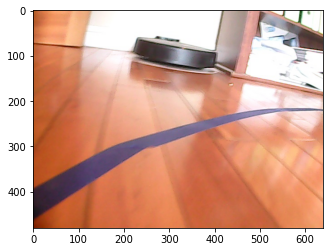

In [22]:
data_root = '/content/gdrive/My Drive/Colab Notebooks/PicarLaneFollow/trainingdata'
data_dir = os.path.join(data_root, 'tape/1.1/*jpg')
file_list = glob.glob(data_dir)
print(len(file_list))
image_paths = []
steering_angles = []
pattern = "*.jpg"
for filename in file_list:
    if fnmatch.fnmatch(filename, pattern) and '(' not in filename:
        image_paths.append(os.path.join(data_dir,filename))
        angle = int(filename.split('.')[-2].split('-')[-1])
        steering_angles.append(angle)

image_index = 20
plt.imshow(Image.open(image_paths[image_index]))
print("image_path: %s" % image_paths[image_index] )
print("steering_Angle: %d" % steering_angles[image_index] )
df = pd.DataFrame()
df['ImagePath'] = image_paths
df['Angle'] = steering_angles

(array([18.0000, 36.0000, 22.0000, 43.0000, 82.0000, 204.0000, 128.0000,
        245.0000, 132.0000, 186.0000, 191.0000, 208.0000, 323.0000,
        371.0000, 329.0000, 425.0000, 402.0000, 350.0000, 95.0000,
        116.0000, 156.0000, 30.0000, 45.0000, 28.0000, 19.0000]),
 array([58.0000, 60.4000, 62.8000, 65.2000, 67.6000, 70.0000, 72.4000,
        74.8000, 77.2000, 79.6000, 82.0000, 84.4000, 86.8000, 89.2000,
        91.6000, 94.0000, 96.4000, 98.8000, 101.2000, 103.6000, 106.0000,
        108.4000, 110.8000, 113.2000, 115.6000, 118.0000]),
 <a list of 25 Patch objects>)

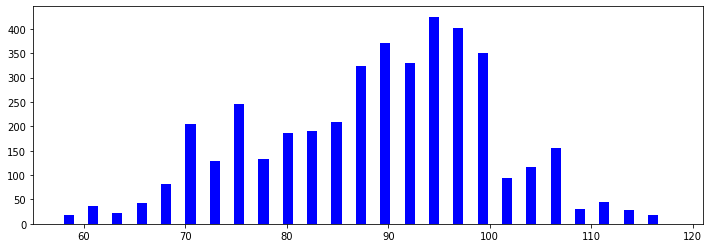

In [23]:
# Look at the distribution of steering angle
num_of_bins = 25
samples_per_bin = 400
hist, bins = np.histogram(df['Angle'], num_of_bins)

fig, axes = plt.subplots(1,1, figsize=(12,4))
axes.hist(df['Angle'], bins=num_of_bins, width=1, color='blue')

Training data: 3347
Validation data: 837


Text(0.5, 1.0, 'Validation Data')

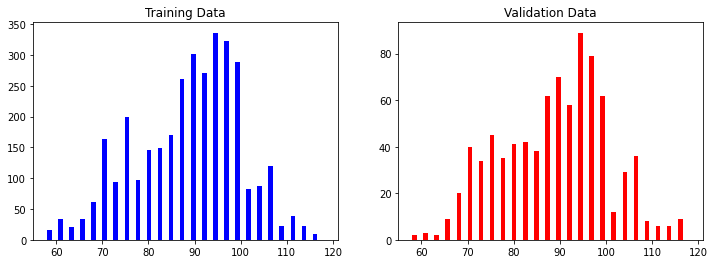

In [24]:
X_train, X_valid, y_train, y_valid = train_test_split( image_paths, steering_angles, test_size=0.2)
print("Training data: %d\nValidation data: %d" % (len(X_train), len(X_valid)))

# plot the distributions of train and valid, make sure they are consistent
fig, axes = plt.subplots(1,2, figsize=(12,4))
axes[0].hist(y_train, bins=num_of_bins, width=1, color='blue')
axes[0].set_title('Training Data')
axes[1].hist(y_valid, bins=num_of_bins, width=1, color='red')
axes[1].set_title('Validation Data')

# Create Model and Train

In [25]:
def mobilenet_model():
    base_model=keras.applications.MobileNetV2(weights='imagenet',include_top=False, input_shape=(img_width, img_height, 3))
    base_model.trainable = True
    inputs = keras.Input(shape=(img_width, img_height, 3))
    data_augmentation = data_augmentation = keras.Sequential([layers.RandomFlip("horizontal")])
    x = data_augmentation(inputs)
    x = base_model(x, training=True)
    x = layers.Flatten()(x)
    x = layers.Dropout(0.2)(x)
    outputs = keras.layers.Dense(1)(x)
    model = keras.Model(inputs, outputs)

    model.summary()
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.003),
        loss='mse',
        metrics=[tf.keras.losses.MeanSquaredError()]
    )
    model.load_weights(model_name)
    return model

In [26]:
def nvidia_model():
    model = Sequential(name='Nvidia_Model')
    
    # elu=Expenential Linear Unit, similar to leaky Relu
    # Convolution Layers
    model.add(Conv2D(24, (5, 5), strides=(2, 2), input_shape=(img_height, img_width, 3), activation='elu')) 
    model.add(Conv2D(36, (5, 5), strides=(2, 2), activation='elu')) 
    model.add(Conv2D(48, (5, 5), strides=(2, 2), activation='elu')) 
    model.add(Conv2D(64, (3, 3), activation='elu')) 
    model.add(Dropout(0.2)) 
    model.add(Conv2D(64, (3, 3), activation='elu')) 
    
    # Fully Connected Layers
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='elu'))
    model.add(Dense(50, activation='elu'))
    model.add(Dense(10, activation='elu'))
    
    # output layer: turn angle (from 40-140, 90 is straight, <90 turn left, >90 turn right)
    model.add(Dense(1)) 
    model.summary()
    
    # since this is a regression problem not classification problem,
    # we use MSE (Mean Squared Error) as loss function
    optimizer = Adam(learning_rate=1e-3)
    model.compile(loss='mse', optimizer=optimizer)
    model.load_weights(model_name)
    
    return model

In [27]:
def imread(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (img_width,img_height))
    return image

def image_data_generator(image_paths, steering_angles, batch_size):
    while True:
        batch_images = []
        batch_steering_angles = []
        
        for i in range(batch_size):
            random_index = random.randint(0, len(image_paths) - 1)
            image_path = image_paths[random_index]
            image = imread(image_paths[random_index])
            steering_angle = steering_angles[random_index]
              
            batch_images.append(image)
            batch_steering_angles.append(steering_angle)
            
        yield( np.asarray(batch_images), np.asarray(batch_steering_angles))

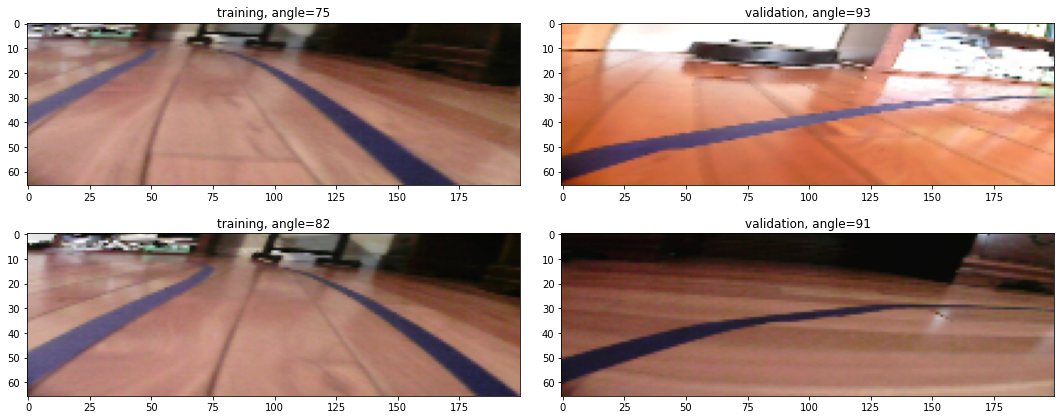

In [28]:
ncol = 2
nrow = 2

X_train_batch, y_train_batch = next(image_data_generator(X_train, y_train, nrow))
X_valid_batch, y_valid_batch = next(image_data_generator(X_valid, y_valid, nrow))

fig, axes = plt.subplots(nrow, ncol, figsize=(15, 6))
fig.tight_layout()

for i in range(nrow):
    axes[i][0].imshow(X_train_batch[i])
    axes[i][0].set_title("training, angle=%s" % y_train_batch[i])
    axes[i][1].imshow(X_valid_batch[i])
    axes[i][1].set_title("validation, angle=%s" % y_valid_batch[i])

In [29]:
# start Tensorboard before model fit, so we can see the epoch tick in Tensorboard
# Jupyter Notebook embedded Tensorboard is a new feature in TF 2.0!!  

# clean up log folder for tensorboard
log_dir_root = f'{model_output_dir}/logs/'
#!rm -rf $log_dir_root

In [ ]:
#model=nvidia_model()
if MODEL=='nvidia':
  model = nvidia_model()
elif MODEL == 'mobilenet':
  model=mobilenet_model()
# saves the model weights after each epoch if the validation loss decreased
checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath=model_name, verbose=1, save_best_only=True)

history = model.fit(x= image_data_generator( X_train, y_train, batch_size=100),
                    steps_per_epoch=300,
                    epochs=10,
                    validation_data = image_data_generator( X_valid, y_valid, batch_size=100),
                    validation_steps=200,
                    verbose=1,
                    shuffle=1,
                    callbacks=[checkpoint_callback])
# always save model output as soon as model finishes training
model.save(model_name)
date_str = datetime.datetime.now().strftime("%y%m%d_%H%M%S")
with open(history_path, 'ab') as f:
    pickle.dump(history.history, f, pickle.HIGHEST_PROTOCOL)


# Check Trained Model on Validation Data

In [ ]:
history.history

In [58]:
# plot training and validation losses
# this should be the same as tensorboard
with open(history_path, 'rb') as f:
    history = pickle.load(f)

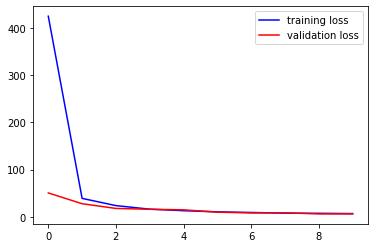

In [61]:
history
plt.plot(history['loss'],color='blue')
plt.plot(history['val_loss'],color='red')
plt.legend(["training loss", "validation loss"])

In [35]:
from sklearn.metrics import mean_squared_error, r2_score

def summarize_prediction(Y_true, Y_pred):
    
    mse = mean_squared_error(Y_true, Y_pred)
    r_squared = r2_score(Y_true, Y_pred)
    
    print(f'mse       = {mse:.2}')
    print(f'r_squared = {r_squared:.2%}')
    print()
    
def predict_and_summarize(X, Y):
    model = load_model(f'{model_name}', compile=False)
    Y_pred = model.predict(X)
    summarize_prediction(Y, Y_pred)
    return Y_pred

837
/content/gdrive/My Drive/Colab Notebooks/PicarLaneFollow/lane_navigation_check_nvidia.h5
mse       = 0.88
r_squared = 99.33%



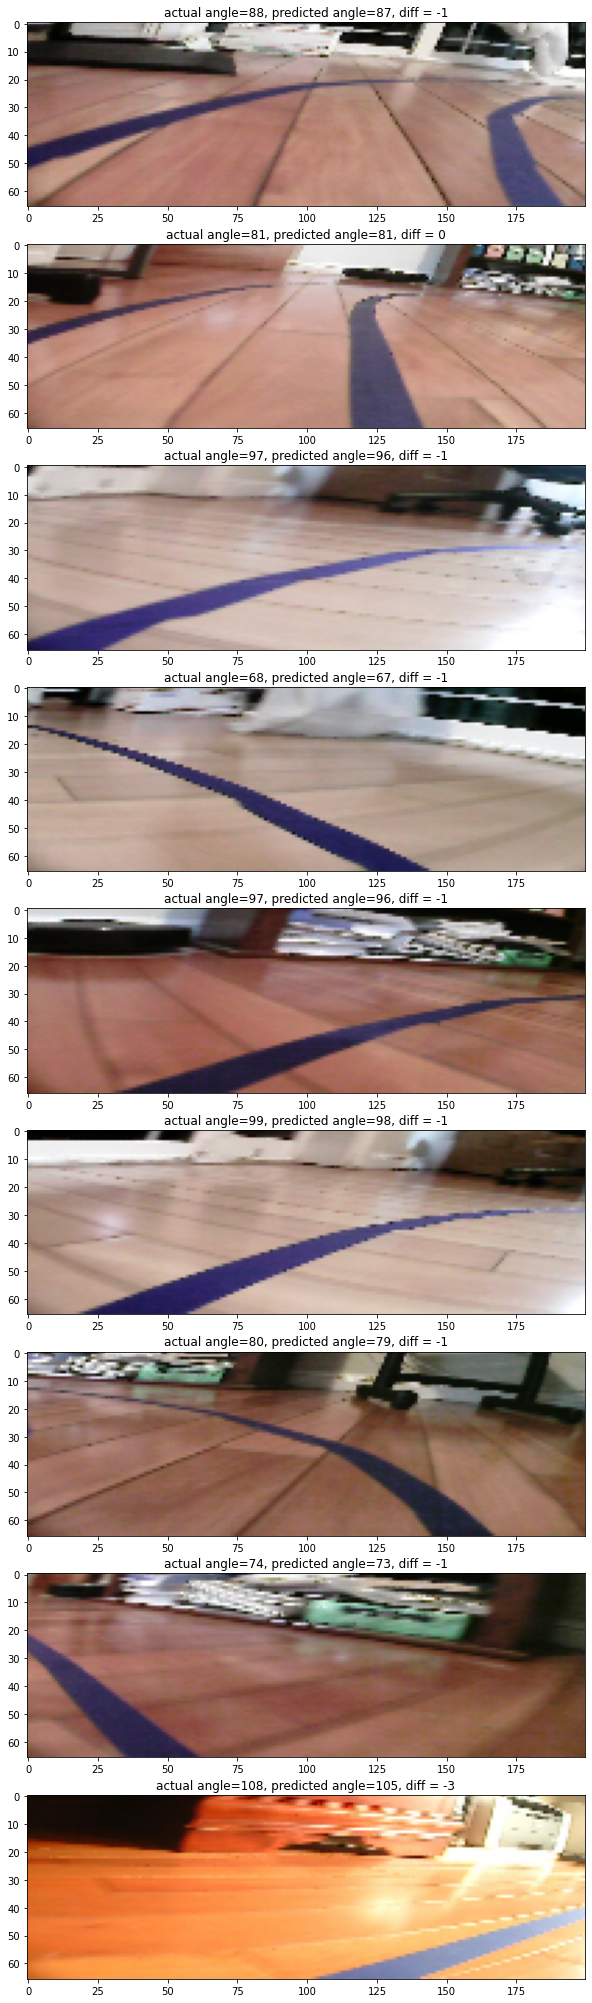

In [36]:
n_tests = len(X_valid)
print(len(X_valid))
print(model_name)
X_test, y_test = next(image_data_generator(X_valid, y_valid, n_tests))

y_pred = predict_and_summarize(X_test, y_test)

n_tests_show = 9
fig, axes = plt.subplots(n_tests_show, 1, figsize=(10, 4 * n_tests_show))
for i in range(n_tests_show):
    axes[i].imshow(X_test[i])
    axes[i].set_title(f"actual angle={y_test[i]}, predicted angle={int(y_pred[i])}, diff = {int(y_pred[i])-y_test[i]}")
    

# TFLite Model

In [37]:
# Convert to TFLite model
trained_model = load_model(f'{model_name}', compile=False)
converter = tf.lite.TFLiteConverter.from_keras_model(trained_model)
tflite_model = converter.convert()
with open(model_name + '.tflite', 'wb') as f:
  f.write(tflite_model)


INFO:tensorflow:Assets written to: /tmp/tmpetw167ea/assets


In [40]:
def tflite_model_test(batch_size = 10):
  X_test, y_test = next(image_data_generator(X_valid, y_valid, batch_size))
  tflite_interpreter = tf.lite.Interpreter(model_path=model_name + '.tflite')
  input_details = tflite_interpreter.get_input_details()
  output_details = tflite_interpreter.get_output_details()

  #Input shape of loaded TFLite model is 1x224x224x3, what means that we can make predictions for single image.
  #Let's resize input and output tensors, so we can make predictions for batch of 32 images.
  tflite_interpreter.resize_tensor_input(input_details[0]['index'], (batch_size, img_height, img_width, 3))
  tflite_interpreter.resize_tensor_input(output_details[0]['index'], (batch_size, 1))
  tflite_interpreter.allocate_tensors()

  input_details = tflite_interpreter.get_input_details()
  output_details = tflite_interpreter.get_output_details()

  tflite_interpreter.set_tensor(input_details[0]['index'], np.array(X_test, dtype=np.float32))
  tflite_interpreter.invoke()

  y_pred = tflite_interpreter.get_tensor(output_details[0]['index'])
  summarize_prediction(y_test, y_pred)

  n_tests_show = 10
  fig, axes = plt.subplots(n_tests_show, 1, figsize=(10, 4 * n_tests_show))
  for i in range(n_tests_show):
    axes[i].imshow(X_test[i])
    axes[i].set_title(f"actual angle={y_test[i]}, predicted angle={int(y_pred[i])}, diff = {int(y_pred[i])-y_test[i]}")


mse       = 1.0
r_squared = 99.18%



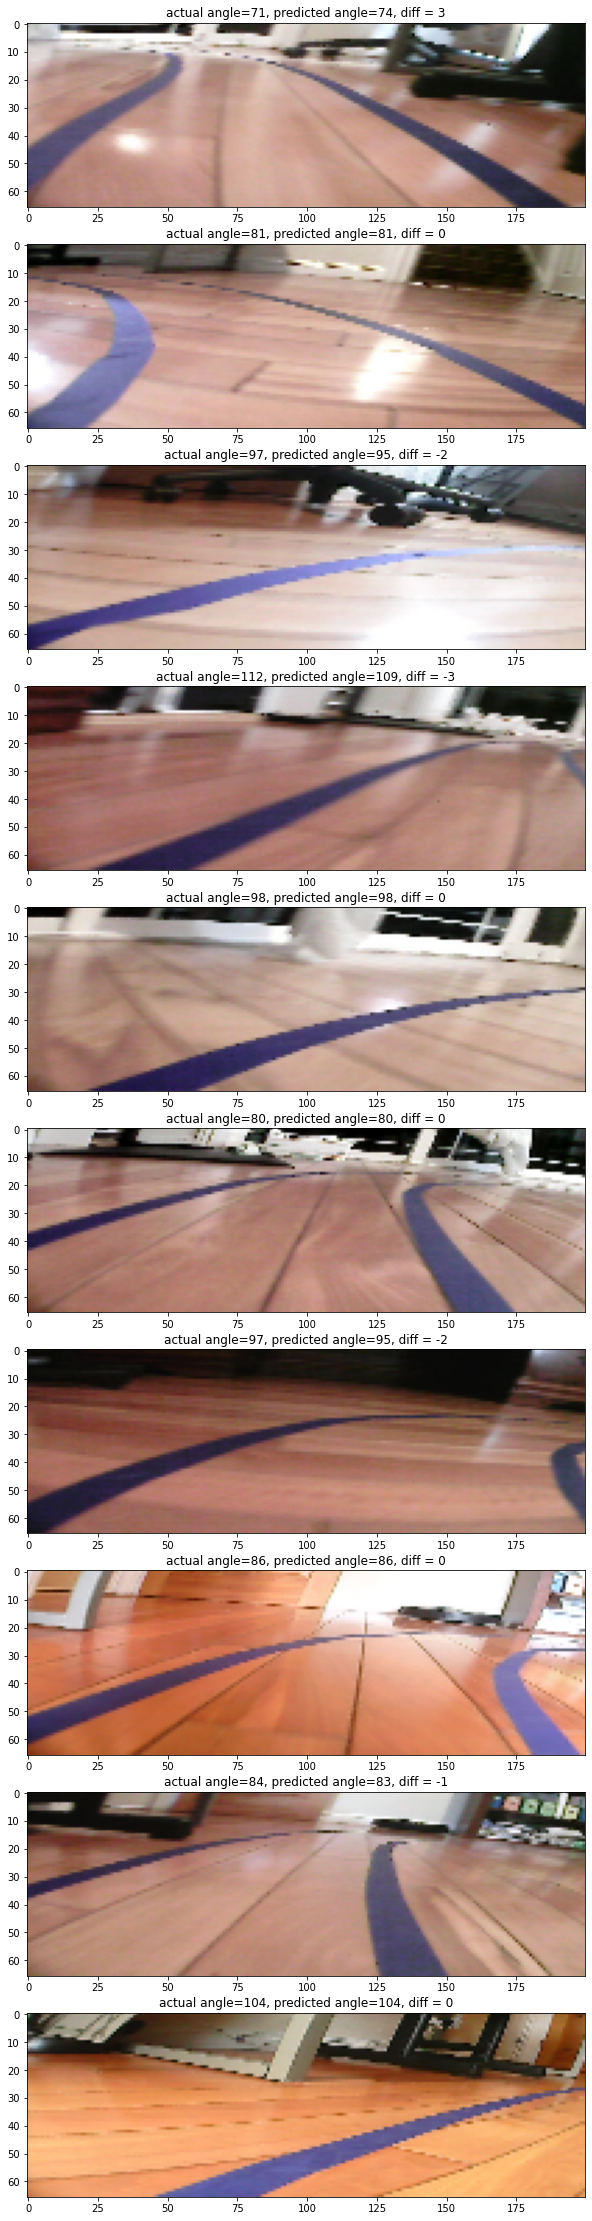

In [41]:
tflite_model_test(len(X_valid))

# Compare with OpenCV

In [56]:
class LineFollowOpencv(object):
    def follow_line(self, image):
        lanes = self.detect_lane(image)
        angle = self.lanes_to_angle(image, lanes)
        # store image and angle for debugging
        #timestr = datetime.utcnow().strftime('%Y-%m-%d-%H-%M-%S.%f')[:-3]
        #cv2.imwrite('/home/pi/Pictures/picar/data/%d-%s.jpg' % (status[0][1], str(angle)), image)
        #if angle is not None and self.front_wheel is not None:
        #    self.front_wheel.turn(angle)
        return angle
    
    def detect_lane(self, image):
        edges = self.detect_edges(image)
        lines = self.detect_line_segments(edges)
        # Keep images where lines are not detected for debug purpose
        lanes = self.merge_to_lanes(image, lines)
        return lanes

    def detect_edges(self, image):
        # Convert the image color to HSV
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        
        # Lift blue
        blue_lower = np.array([80, 40, 40])
        blue_upper = np.array([170, 255, 255])
        blue = cv2.inRange(hsv, blue_lower, blue_upper)
        
        # Detect edges
        edges = cv2.Canny(blue, 100, 200)
        
        # Only focus bottom half of the screen
        # Create mask for upper half
        height, width = edges.shape
        mask = np.zeros_like(edges)

        polygon = np.array([[
            (0, height * 1 / 2), (width, height * 1 / 2), # top left corner
            (width, height), (0, height),  # bottom right corner
        ]], np.int32)

        cv2.fillPoly(mask, polygon, 255)
        filtered_edges = cv2.bitwise_and(edges, mask)
        return filtered_edges

    def detect_line_segments(self, edges):
        # detect line segments
        rho = 1  # distance precision in pixel, i.e. 1 pixel
        angle = np.pi / 180  # angular precision in radian, i.e. 1 degree
        min_threshold = 10  # minimal of votes
        line_segments = cv2.HoughLinesP(
            edges, rho, angle, min_threshold,
            np.array([]), minLineLength=10, maxLineGap=4)
        return line_segments

    def merge_to_lanes(self, image, lines):
        if lines is None:
            return None
        left = []  # lines for left lane
        right = []  # lines for right lane
        height, width, _ = image.shape

        # Only collect lines at the left 1/2 for the left lane, similar for right lane
        boundary = 1/2
        left_region_boundary = width * (1 - boundary)
        right_region_boundary = width * boundary

        for line in lines:
            x1, y1, x2, y2 = line.reshape(4)
            # Skip vertical line since the slope is infinite
            if x1 == x2:
                continue
            parameters = np.polyfit((x1, x2), (y1, y2), 1)
            slope = parameters[0]
            y_int = parameters[1]

            if slope < 0:
                if x1 < left_region_boundary and x2 < left_region_boundary:
                    left.append((slope, y_int))
            else:
                if x1 > right_region_boundary and x2 > right_region_boundary:
                    right.append((slope, y_int))
        
        lanes = []
        if len(left) > 0:
            left_avg = np.average(left, axis=0)
            lanes.append(self.make_points(image, left_avg))

        if len(right) > 0:
            right_avg = np.average(right, axis=0)
            lanes.append(self.make_points(image, right_avg))

        return lanes

    def make_points(self, image, average): 
        height, width, _ = image.shape
        slope, intercept = average
        y1 = height  # bottom of the frame
        y2 = int(y1 * 1 / 2)  # make points from middle of the frame down

        x1 = max(-width, min(2 * width, int((y1 - intercept) / slope)))
        x2 = max(-width, min(2 * width, int((y2 - intercept) / slope)))
        return [x1, y1, x2, y2]

    def lanes_to_angle(self, image, lanes):
        if lanes is None or len(lanes) == 0:
            return None
        height, width, _ = image.shape
        mid = int(width / 2)

        # If there are two lanes, the direction line is in the middle
        if len(lanes) == 2:
            _, _, left_x2, _ = lanes[0]
            _, _, right_x2, _ = lanes[1]
            x_offset = (left_x2 + right_x2) / 2 - mid
            y_offset = int(height / 2)
        # If there is only one lane, follow the direction of the only lane
        elif len(lanes) == 1:
            x1, _, x2, _ = lanes[0]
            x_offset = x2 - x1
            y_offset = int(height / 2)
        
        # Calculate angels from direction line
        angle_radian = math.atan(x_offset / y_offset)  # angle (in radian)
        angle_degree = int(angle_radian * 180.0 / math.pi)  # angle (in degrees)
        steering_angle = angle_degree + 90  # steering angle

        # Display direction line
        cv2.line(image, (int(width/2), height),
                (int(x_offset + mid), int(height/2)), (255, 255, 0), 5)
        return steering_angle

15
(66, 200, 3)


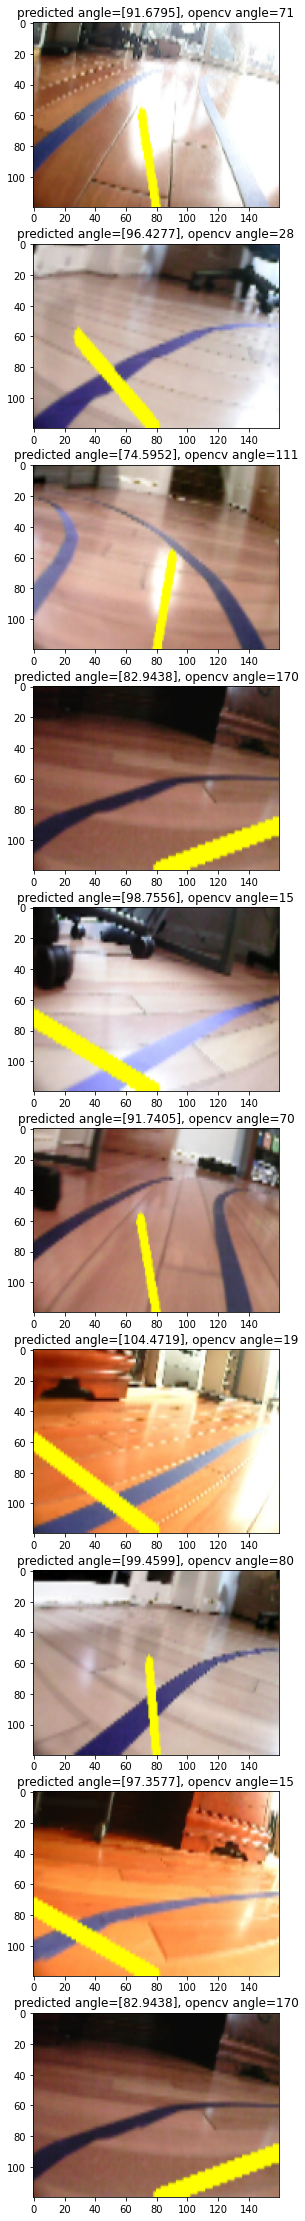

In [57]:
def compare_with_opencv(batch_size = 10):
  X_test, y_test = next(image_data_generator(X_valid, y_valid, batch_size))
  tflite_interpreter = tf.lite.Interpreter(model_path=model_name + '.tflite')
  input_details = tflite_interpreter.get_input_details()
  output_details = tflite_interpreter.get_output_details()

  #Input shape of loaded TFLite model is 1x224x224x3, what means that we can make predictions for single image.
  #Let's resize input and output tensors, so we can make predictions for batch of 32 images.
  tflite_interpreter.resize_tensor_input(input_details[0]['index'], (batch_size, img_height, img_width, 3))
  tflite_interpreter.resize_tensor_input(output_details[0]['index'], (batch_size, 1))
  tflite_interpreter.allocate_tensors()

  input_details = tflite_interpreter.get_input_details()
  output_details = tflite_interpreter.get_output_details()

  tflite_interpreter.set_tensor(input_details[0]['index'], np.array(X_test, dtype=np.float32))
  tflite_interpreter.invoke()

  y_pred = tflite_interpreter.get_tensor(output_details[0]['index'])


  diff_index = []
  opencv_angles = []
  opencv_line = LineFollowOpencv()
  for i in range(len(X_test)):
      opencv_angle = opencv_line.follow_line(X_test[i])
      opencv_angles.append(opencv_angle)
      if opencv_angle is not None and ((y_pred[i] > 90 and opencv_angle < 90) or (y_pred[i] < 90 and opencv_angle > 90)):
          diff_index.append(i)
          
  print(len(diff_index))
  
  n_tests_show = 10
  fig, axes = plt.subplots(n_tests_show, 1, figsize=(10,40))
  for i in range(min(10, len(diff_index))):
      axes[i].imshow(cv2.resize(X_test[diff_index[i]].astype('uint8'), (160,120)))
      axes[i].set_title(f"predicted angle={y_pred[diff_index[i]]}, opencv angle={int(opencv_angles[diff_index[i]])}")
    
compare_with_opencv(100)